# Jupyter Notebook to make the figures I need in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import classy
import os
import matplotlib
import healpy as hp
from scipy import interpolate as itp
from scipy import stats

In [2]:
#I need this function to load the mixing matrix 
def __one_dim_index(Bin1, Bin2):
    """
    This function is used to convert 2D sums over the two indices (Bin1, Bin2)
    of an N*N symmetric matrix into 1D sums over one index with N(N+1)/2
    possible values.
    """
    if Bin1 <= Bin2:
        return Bin2 + nzbins * Bin1 - (Bin1 * (Bin1 + 1)) // 2
    else:
        return Bin1 + nzbins * Bin2 - (Bin2 * (Bin2 + 1)) // 2

In [3]:
#useful quantities
nzbins = 5
nbins = 8
nzcorrs = nzbins * (nzbins + 1) // 2
nl = 3069
lll = range(2, 3071)
#lll = range(2,3001)
#nells=50
ells = np.logspace(np.log10(76), np.log10(1500), 50)
ellbin = np.logspace(np.log10(76), np.log10(1500), 8+1)
BIN_EDGES = ellbin
# ell-bin edges and pixel window function:
pixWin = (np.power(hp.pixwin(1024, pol=True, lmax=3070), 2)[0])
pixWinB = (np.power(hp.pixwin(1024, pol=True, lmax=2999), 2)[0])
ellPclsBin_edges = np.logspace(np.log10(76), np.log10(1500), 9)


## Loading the data vector, the covariance matrix and the theory vector  

In the end of this cell we split the data and theory vectors into 15 bins.

_Remark_ : the theory vectors are the Pseudo-Cl, hence they don't need to be recast by taking the product with the mixing matrix.

In [4]:
#data vector
data_vec_path = os.path.join('/Users/matteograsso/Desktop/DATA/kids1000_pcl/DATA/', 'PKWL-EE-DATAVEC.dat')
data_vec = np.loadtxt(data_vec_path)
#covariance matrix
covmat_path = os.path.join('/Users/matteograsso/Desktop/DATA/kids1000_pcl/DATA/', 'PKWL-Covariance-Matrix.dat')
covmat = np.loadtxt(covmat_path)

# Read covariance matrix
#covmat = self.__load_legacy_covmat()
pixelwind_path = os.path.join('/Users/matteograsso/Desktop/DATA/kids1000_pcl/DATA/', 'PIXEL_WINDOW_NSIDE1024_EMODE.dat')
pixelwind = np.loadtxt(pixelwind_path)

#read mixing matrix
mixmat = np.zeros((nzcorrs, 3069, 3069))
for Bin1 in range(nzbins):
    for Bin2 in range(Bin1, nzbins):
        indexcorr = __one_dim_index(Bin1,Bin2)
        mixmat_file_path = os.path.join('/Users/matteograsso/Desktop/DATA/kids1000_pcl/DATA/', 'MIXING_MATRIX/z{0:}z{1:}.npy'.format(Bin1+1, Bin2+1))
        mixmat[indexcorr] = np.load(mixmat_file_path)

#loading the theory vectors
home = '/Users/matteograsso/Desktop/MSc_thesis/Paper_notebook/Paper_plots'
hor_massive_nu = np.loadtxt('/Users/matteograsso/Desktop/pcl_massive_neutrinos.dat')
hor_k1k = np.loadtxt(home + '/pcl_hor_k1k.dat')
lcdm_planck = np.loadtxt(home + '/Pcl_planck_bf.dat')
lcdm_k1k = np.loadtxt(home + '/pcl_best_k1k.dat')
hor_nobar_screened = np.loadtxt('PCL_nobar_screened.dat')
hor_nobar_unscreened = np.loadtxt('PCL_nobar_unscreened.dat')
hor_bar_screened = np.loadtxt('PCL_screened.dat')
hor_bar_unscreened  = np.loadtxt('PCL_unscreened.dat')
boss_hor = np.loadtxt(home + '/pcl_baorsd_bf.dat')
planck_hor = np.loadtxt(home + '/pcl_cmb_bf.dat')

#DATA POINTS & HORNDESKI TH. 
data_binned = np.array_split(data_vec,15)
hor_k1k_binned = np.array_split(hor_k1k, 15) #this should be equal to hor_bar_screened
hor_nobar_unscreened_binned = np.array_split(hor_nobar_unscreened,15)
hor_nobar_screened_binned = np.array_split(hor_nobar_screened,15)
hor_bar_unscreened_binned = np.array_split(hor_bar_unscreened,15)
hor_bar_screened_binned = np.array_split(hor_bar_screened,15)
#prova_binned = np.array_split(prova,15)

#PLANCK LCDM
lcdm_planck_binned = np.array_split(lcdm_planck, 15)
#lcdm_planck_again_binned = np.array_split(lcdm_planck_again,15)
lcdm_k1k_binned = np.array_split(lcdm_k1k, 15)

#BOSS 
boss_hor_binned = np.array_split(boss_hor,15)

#PLANCK HORNDESKI
planck_hor_binned = np.array_split(planck_hor,15)

# getting the error-bars from the covariance:
mocksVarGold = covmat.diagonal().reshape(15,8)

Here we create pandas data frames; each column of the data frame corresponds to a bin (e.g. column 1 = E1-E1 mode)

In [6]:
names = []
for i in range(1,6):
    for j in range(1,6):
        if i > j:
            #axis[i,j].axis('off')
            None
        else:
            x = f'E{i}-E{j}' 
            names.append(x) 
            
df_data = pd.DataFrame()
df_errorbar = pd.DataFrame()

df_hor_k1k = pd.DataFrame() #Horndeski
df_lcdm_planck= pd.DataFrame() #planck LCDM
df_lcdm_planck_again = pd.DataFrame() 
df_lcdm_k1k = pd.DataFrame() #KiDS LCDM
df_boss_hor = pd.DataFrame() #BOSS Horndeski
df_planck_hor = pd.DataFrame() #planck Horndeski

df_hor_nobar_screened = pd.DataFrame() #Horndeski, no baryonic feedback, screened
df_hor_nobar_unscreened = pd.DataFrame() #Horndeski, no baryonic feedback, UNscreened
df_hor_bar_screened = pd.DataFrame() #Horndeski, baryonic feedback, screened
df_hor_bar_unscreened = pd.DataFrame() #Horndeski, baryonic feedback, UNscreened


for i in range(len(data_binned)):
    df_data[names[i]] = data_binned[i]*1e7
    df_hor_k1k[names[i]] =  hor_k1k_binned[i]*1e7
    df_lcdm_planck[names[i]] = lcdm_planck_binned[i]*1e7
    df_lcdm_k1k[names[i]] = lcdm_k1k_binned[i]*1e7   
    df_boss_hor[names[i]] = boss_hor_binned[i]*1e7
    df_planck_hor[names[i]] = planck_hor_binned[i]*1e7
    df_hor_nobar_screened[names[i]] = hor_nobar_screened_binned[i]*1e7
    df_hor_nobar_unscreened[names[i]] = hor_nobar_unscreened_binned[i]*1e7
    df_hor_bar_screened[names[i]] = hor_bar_screened_binned[i]*1e7
    df_hor_bar_unscreened[names[i]] = hor_bar_unscreened_binned[i]*1e7
    #df_prova[names[i]] = prova_binned[i]*1e7
    
    #df_plot_for_Benjamin_kids[names[i]] = lcdm_k1k_binned[i]*1e7
    #df_plot_for_Benjamin_planck[names[i]] = planck_k1k_binned[i]*1e7
    #df_hor_lcdm[names[i]] = lcdm_hor_binned[i]*1e7
    df_errorbar[names[i]] = np.sqrt(mocksVarGold[i])*1e7

## Here I am trying to plot E4-E4, E5-E4, E5-E5 only

In [12]:
pixWin[2:]

array([0.99999967, 0.99999932, 0.99999881, ..., 0.41864238, 0.4183943 ,
       0.41814627])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


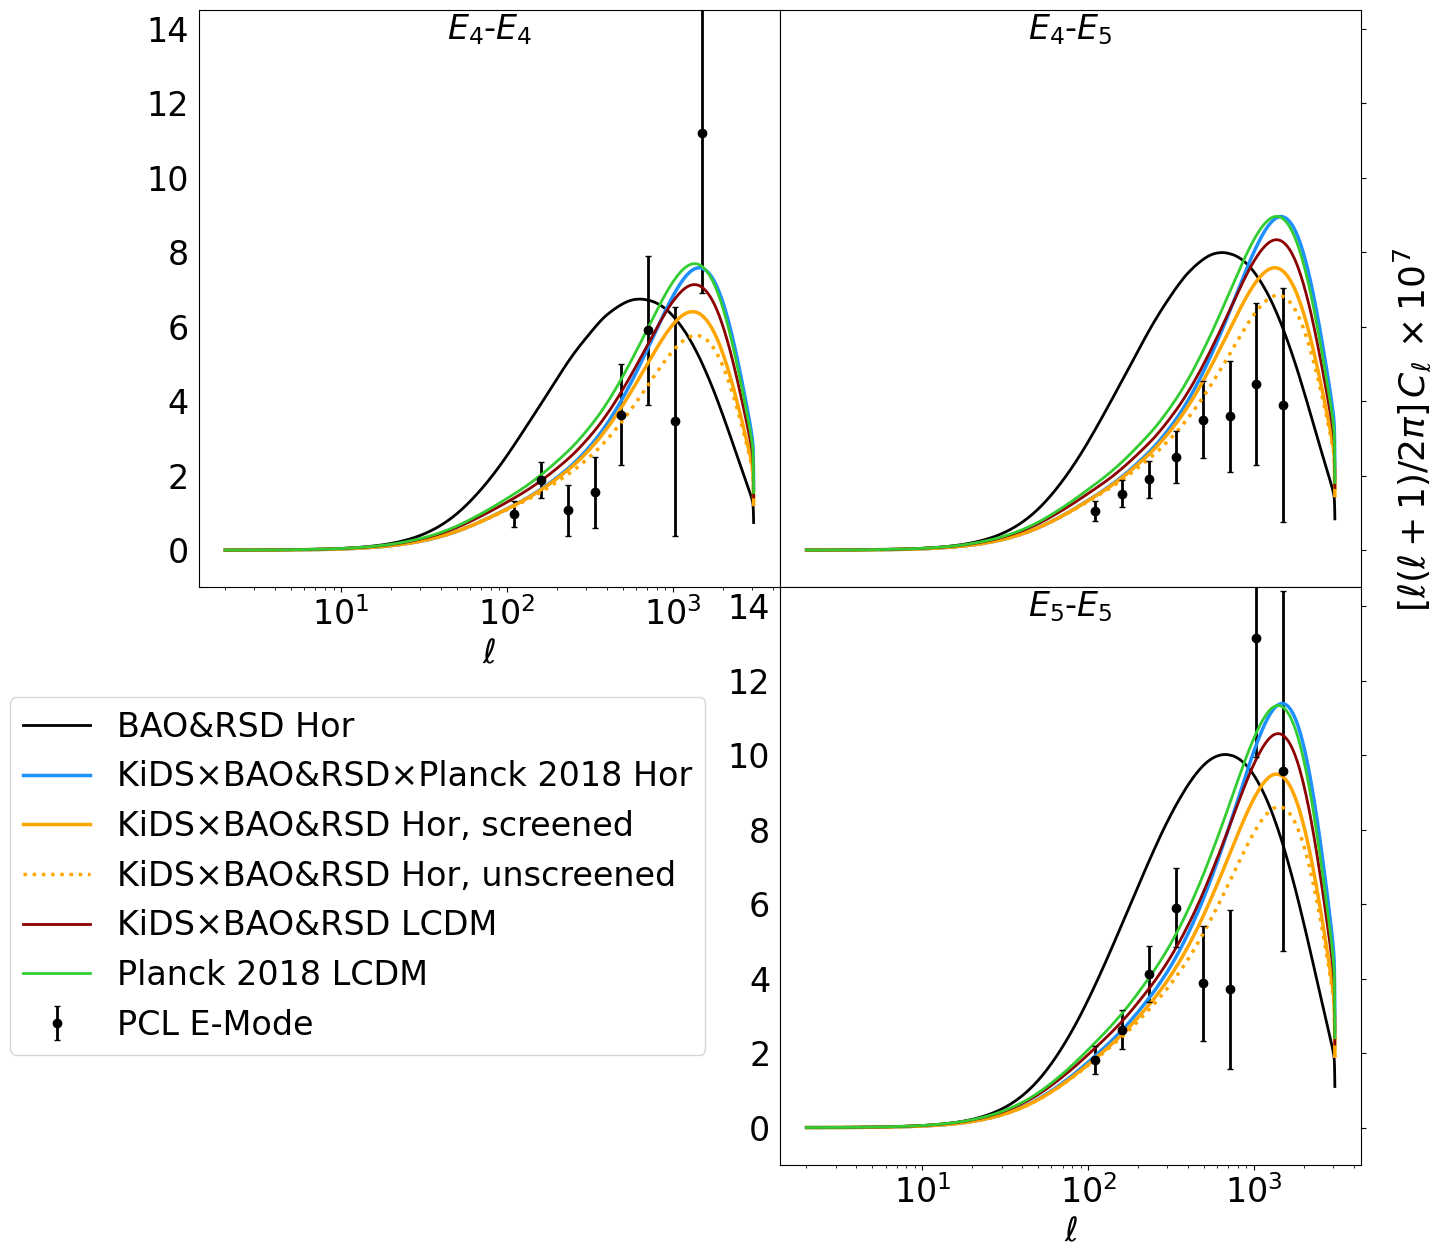

In [9]:
colours_bins = ['#FF595E', '#FFCA3A', '#8AC926', '#1982C4', '#6A4C93', 	'#4C936A']
plt.rcParams.update({'font.size': 24})
fig, axis = plt.subplots(figsize=(15,15), sharex='col', sharey=True, ncols=2, nrows=2, gridspec_kw={'wspace': 0, 'hspace': 0})

for i in range(0,2):
    for j in range(0,2):
        if i>j: 
            axis[i,j].axis('off')
        else:    
            name = f'E{i+4}-E{j+4}'
            title = f'$E_{i+4}$-$E_{j+4}$'
            axis[i,j].text(.5, .95, f"{title}", fontsize=24, horizontalalignment='center',
            transform=axis[i,j].transAxes)
            #axis[i,j].axhline(0, ls='--', color='k')
            axis[i,j].set_xscale('log')
            axis[i,j].yaxis.tick_right()
            #axis[i,j].yaxis.set_tick_params(which='minor', labelright='on', labelleft='off')
            # make some labels invisible
            axis[i,j].xaxis.set_tick_params(labelbottom=True)
            axis[i,j].yaxis.set_tick_params(labelleft=True)
            #axis[i-1,j].set_xlim(50,2000)
    
            #BOSS (HORNDESKI)
            axis[i,j].plot(lll[:], df_boss_hor[name]*pixWin[2:], 
                           label='BAO&RSD Hor ', linestyle = '-', color='black', linewidth=2)#c=colours_bins[5])
            #PLANCK (HORNDESKI)
            axis[i,j].plot(lll[:], df_planck_hor[name]*pixWin[2:], 
                           label='KiDS×BAO&RSD×Planck 2018 Hor', linestyle = '-', color='dodgerblue', linewidth=2.5)#c=colours_bins[5])
            #HORNDESKI 
            #axis[i,j].plot(lll[:], df_hor_nobar_screened[name]*pixWin[2:], 
                           #label='Hor KiDS-1000 $P\mathcal{C}_l$ + BAO & RSD, no baryonic feedback + S', linestyle = '-.', c=colours_bins[2])
            #THIS ONE IS THE BEST-FIT
            axis[i,j].plot(lll[:], df_hor_bar_screened[name]*pixWin[2:], 
                           label='KiDS×BAO&RSD Hor, screened', linestyle = '-', color='orange', linewidth=2.5) #c=colours_bins[3])
            #THIS ONE IS THE BEST-FIT UNSCREENED
            axis[i,j].plot(lll[:], df_hor_bar_unscreened[name]*pixWin[2:], 
                           label='KiDS×BAO&RSD Hor, unscreened ', linestyle = ':', color='orange',linewidth=2.5)#c=colours_bins[4])
            
        
            #KIDS-1000 + BOSS LCDM
            axis[i,j].plot(lll[:], df_lcdm_k1k[name]*pixWin[2:], 
                           label='KiDS×BAO&RSD LCDM',  linestyle = '-', color='darkred', linewidth=2.)#c=colours_bins[0])
            
            #PLANCK LCDM
            axis[i,j].plot(lll[:], df_lcdm_planck[name]*pixWin[2:], label='Planck 2018 LCDM', linestyle = '-', color='limegreen', linewidth=2. )
            
            
            #DATA VECTOR
            axis[i,j].errorbar(ellbin[1:], df_data[name], yerr=df_errorbar[name], 
                         label='PCL E-Mode', fmt="o", capsize=2, elinewidth=2, color = 'k')

            axis[i,j].set_xlabel("$\ell$", fontsize=24)

            plt.legend(loc = 'center right', bbox_to_anchor=(-0.1, 0.5));
            
fig.text(0.92, 0.6, r"$[\ell(\ell+1)/2\pi]\, C_{\ell} \,\times 10^{7}$"  , va='center', rotation='vertical', fontsize= 26)
axis[0,0].set_ylim(-.5,1.3e-6*1e7)
axis[0,1].set_ylim(-.5,1.3e-6*1e7)
axis[1,0].set_ylim(-1,1.45e-6*1e7)

# make some labels invisible
axis[0,1].xaxis.set_tick_params(labelbottom=False)
axis[0,1].yaxis.set_tick_params(labelleft=False)

            
plt.savefig('/Users/matteograsso/Desktop/PCl.png', format='png')
            

## Finally, we get the PCl plot !

I am probably missing a factor $2$. Double check the likelihood (I probably divided by $\pi$ rather than $2 \pi$, or sth similar)

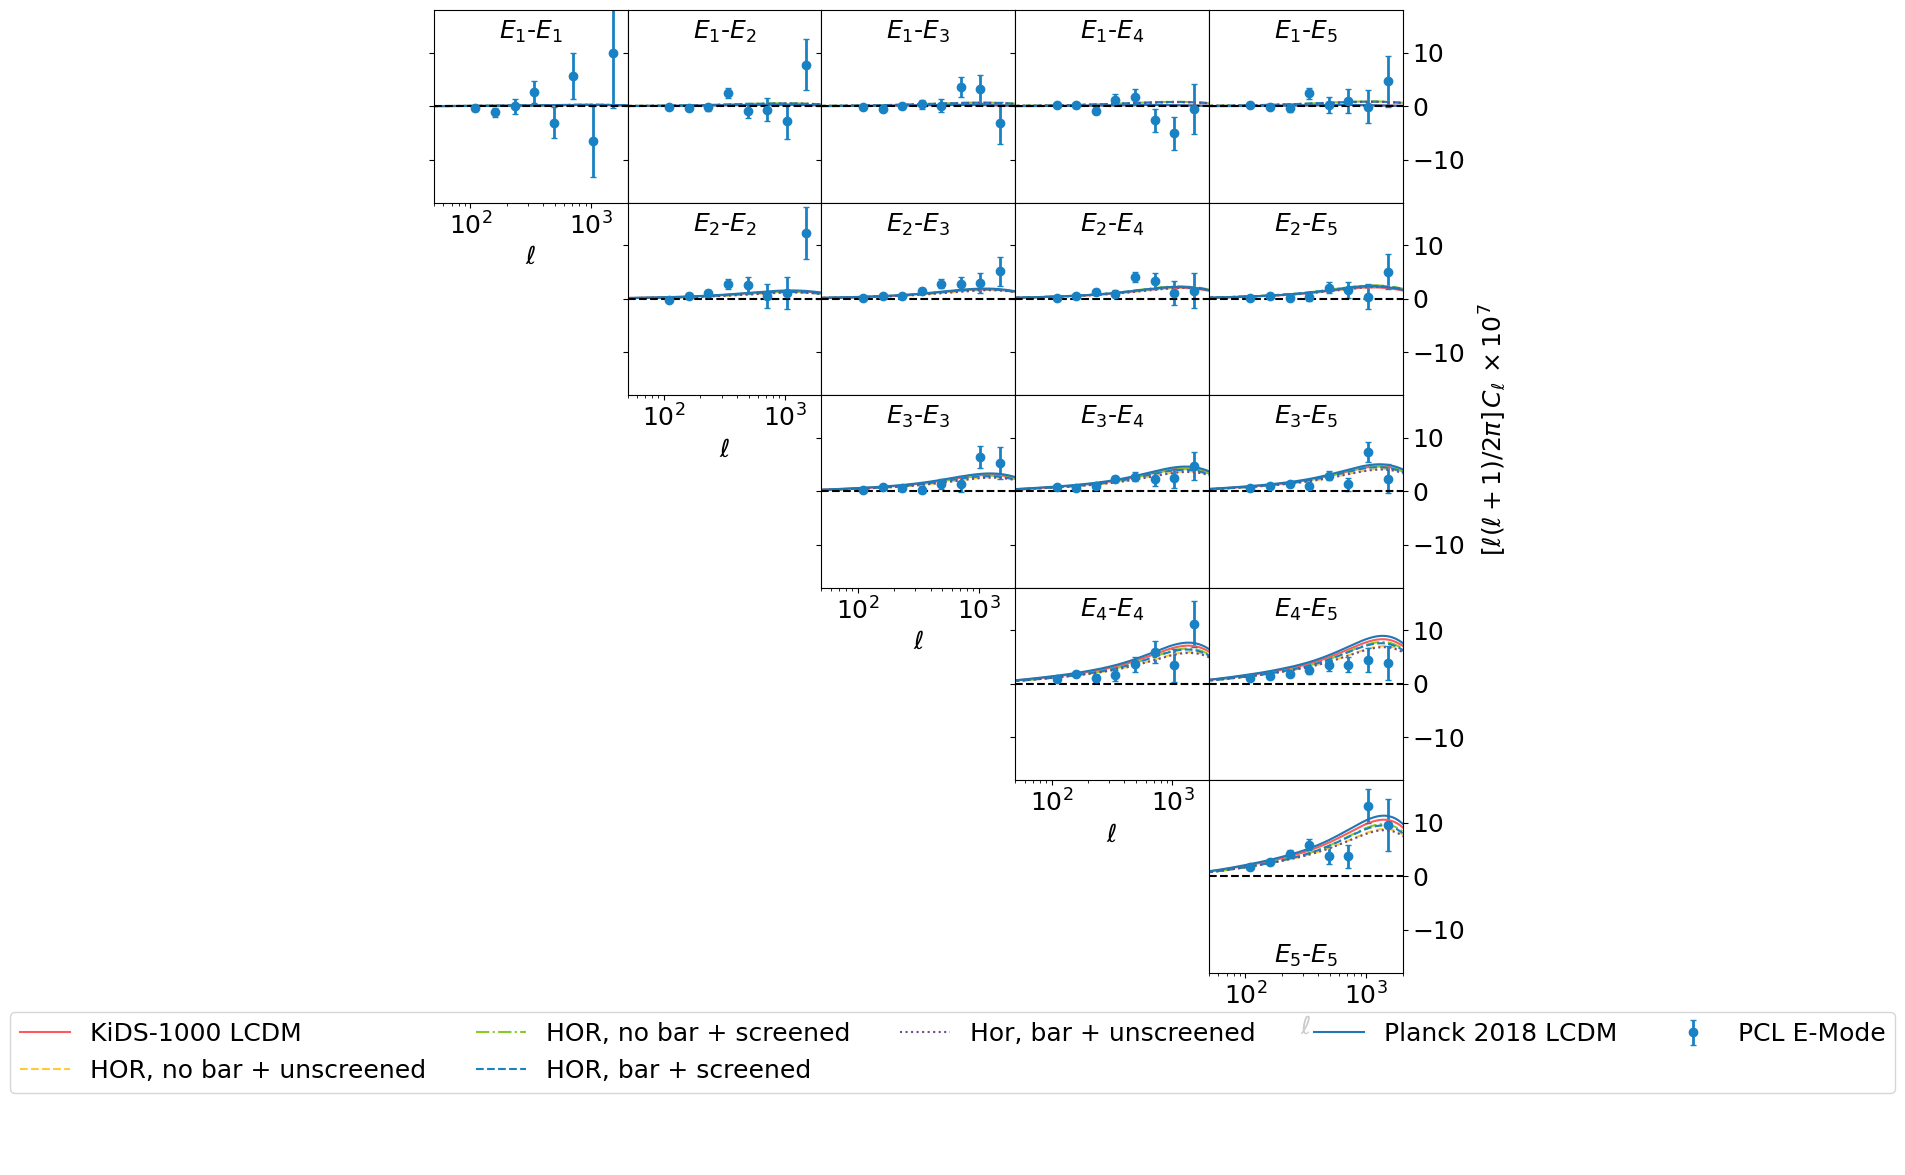

In [49]:
# Defining some colour schemes:
#fac = 1e7
#factPCL_th = lll/(lll*(np.add(lll,1))/(2*np.pi))
#factPCL_da = ellbin/(ellbin*(ellbin+1)/(2*np.pi))

colours_bins = ['#FF595E', '#FFCA3A', '#8AC926', '#1982C4', '#6A4C93']
plt.rcParams.update({'font.size': 18})
fig, axis = plt.subplots(figsize=(15,15), sharex='col', sharey=True, ncols=6, nrows=6, gridspec_kw={'wspace': 0, 'hspace': 0})

axis[0,0].axis('off')
plt.setp(axis[0,1].get_xticklabels(), visible=True)

for i in range(1,6):
    axis[i,0].axis('off')
    for j in range(1,6):
        if i > j:
            axis[i,j].axis('off')
            None
        else:
            name = f'E{i}-E{j}'
            title = f'$E_{i}$-$E_{j}$'
            
            if (i==5) and (j==5):
                axis[i-1,j].text(.5, .05, f"{title}", fontsize=18, 
                             horizontalalignment='center',
                             transform=axis[i-1,j].transAxes)
                
            else:
                axis[i-1,j].text(.5, .85, f"{title}", fontsize=18, 
                             horizontalalignment='center',
                             transform=axis[i-1,j].transAxes)
            
            axis[i,j].set_xscale('log')
            axis[i,j].set_xlim(50,2000)
            #axis[i,j].set_ylim(-1.1e-6*fac,1.8e-6*fac)
            plt.tick_params(axis='x', which='minor')
            axis[i-1,j].set_xlabel(r"$\ell$")
            #plt.ylim(-1e-6*fac,2.e-6*fac)
            
            
            if i == j: 
                axis[i,j].axis('off')
                
            #################################################
            ####### E MODES (UPPER TRIANGLE) ################
            #################################################
            
            # theory:
            #axis[i-1,j].plot(lll[:], df_k1k_lcdm[name][2:3001]*pixWin[2:3001], label='LCDM Best Fit', c=colours_bins[0])
            axis[i-1,j].plot(lll[:], df_lcdm_k1k[name]*pixWin[2:], label='KiDS-1000 LCDM', c=colours_bins[0])
            #axis[i-1,j].plot(lll[:], df_hor_k1k[name]*pixWin[2:], label='Horndeski Best Fit', linestyle = '--', c=colours_bins[1])
            axis[i-1,j].plot(lll[:], df_hor_nobar_unscreened[name]*pixWin[2:], label='HOR, no bar + unscreened', linestyle = '--', c=colours_bins[1])
            axis[i-1,j].plot(lll[:], df_hor_nobar_screened[name]*pixWin[2:], label='HOR, no bar + screened', linestyle = '-.', c=colours_bins[2])
            axis[i-1,j].plot(lll[:], df_hor_bar_screened[name]*pixWin[2:], label='HOR, bar + screened', linestyle = '--', c=colours_bins[3])
            axis[i-1,j].plot(lll[:], df_hor_bar_unscreened[name]*pixWin[2:], label='Hor, bar + unscreened ', linestyle = ':', c=colours_bins[4])
            axis[i-1,j].plot(lll[:], df_lcdm_planck[name]*pixWin[2:], label='Planck 2018 LCDM', linestyle = '-' )
            # data vector
            axis[i-1,j].errorbar(ellbin[1:], df_data[name], yerr=df_errorbar[name], 
                               label='PCL E-Mode', fmt="o", capsize=2, elinewidth=2, c=colours_bins[3])
#             axis[i-1,j].errorbar(Pcls_ALT['ELLS'], Pcls[name]*fac*factPCL, yerr=np.sqrt(mVarDictGold[name])*fac*factPCL, 
#                                label='PCL E-Mode alt', fmt="o", capsize=2, elinewidth=2, )
            
            # zero lines:
            axis[i-1,j].axhline(0, ls='--', color='k')
            axis[i-1,j].set_xscale('log')
            axis[i-1,j].set_xlim(50,2000)
            axis[j,i-1].set_ylim(-1.8e-6*1e7,1.8e-6*1e7)
            
            
            
            # solving the xticks issue!
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            axis[j,i-1].xaxis.set_major_locator(x_major)
            axis[i-1,j].xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            axis[j,i-1].xaxis.set_minor_locator(x_minor)
            axis[j,i-1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            axis[i,j].xaxis.set_minor_locator(x_minor)
            axis[i,j].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            axis[i-1,j].xaxis.set_tick_params(which='both', labelbottom=True)
            
            axis[i,5].yaxis.set_tick_params(which='both', labelright='on', labelleft='off')
            axis[i,5].yaxis.tick_right()
            
            
            #axis[i,j].yaxis.set_ticks_position('both')

            
            
#axis[0,1].legend(loc=0, ncol=1, bbox_to_anchor=(-0.1,0.435), fontsize=15)
#axis[5,4].legend(loc=0, ncol=1, bbox_to_anchor=(1,1), fontsize=15)
handlesE, labelsE = axis[0,1].get_legend_handles_labels()
handlesB, labelsB = axis[1,0].get_legend_handles_labels()
fig.legend(handlesE + handlesB, labelsE + labelsB, loc='lower center', ncol=5, bbox_transform = plt.gcf().transFigure, bbox_to_anchor = (.1,.15,1,1))

axis[5,0].set_xlabel("$\ell$")
axis[5,1].set_xlabel("$\ell$")
axis[5,2].set_xlabel("$\ell$")
axis[5,3].set_xlabel("$\ell$")
axis[5,4].set_xlabel("$\ell$")

axis[0,5].yaxis.set_tick_params(which='both', labelright='on', labelleft='off')
axis[0,5].yaxis.tick_right()


#fig.text(0.5, -0.14, r"$\ell$", ha='center')
fig.text(0.95, 0.6, r"$[\ell(\ell+1)/2\pi]\, C_{\ell} \,\times 10^{7}$"  , va='center', rotation='vertical')

#             if i == 4:
#                 axis[i-1,j].legend(loc=0, ncol=1, bbox_to_anchor=(-3.5,1))

plt.savefig('all.png', bbox_inches='tight')            
            

In [17]:
factPCL_data = [] #I am evaluating this factor in the center of every bin 
bin_means = []
for i in range(len(ellbin)-1):
    bin_mean = (ellbin[i] + ellbin[i+1])/2
    bin_means.append(bin_mean)
    factPCL_data.append(bin_mean/(bin_mean*(bin_mean+1)/(2*np.pi)))

In [18]:
from scipy.interpolate import interp1d
f_lcdm_planck = pd.DataFrame()
xnew = bin_means
for i in names:
    x = lll[:]
    y = factPCL_th* df_lcdm_planck[i]*pixWin[2:]
    interp_y = interp1d(x, y, bounds_error=False, kind='cubic')
    f_lcdm_planck[i] = interp_y(xnew)


## Relative differences

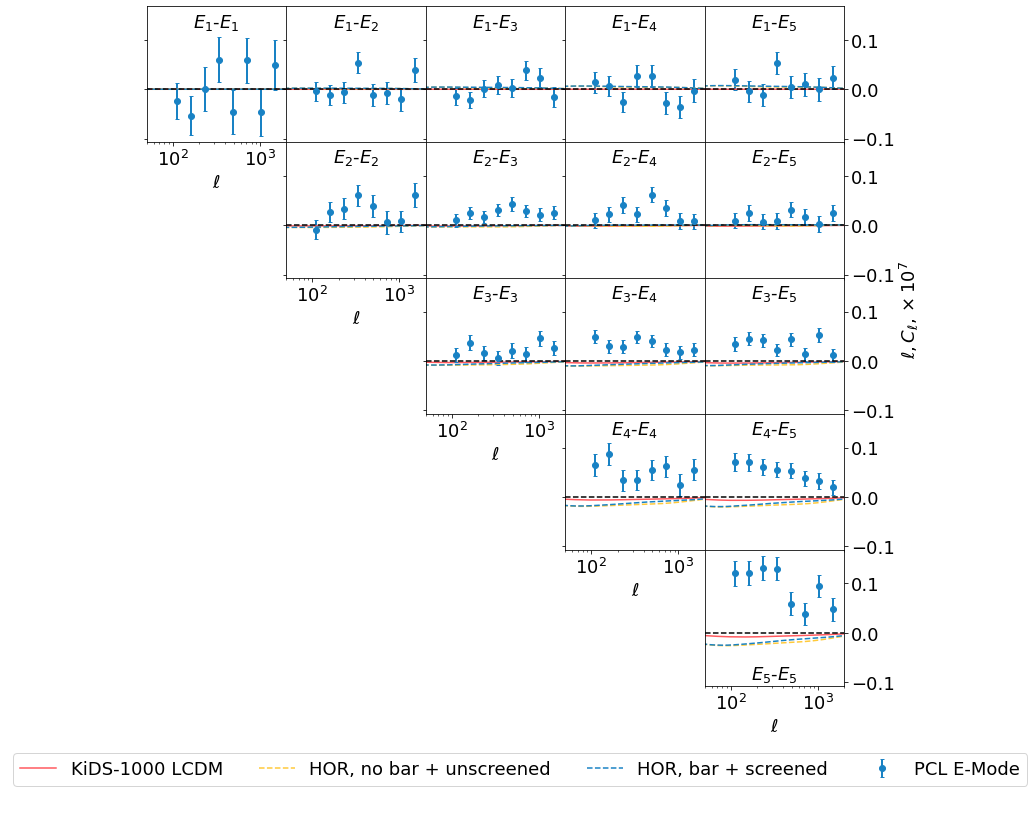

In [21]:
# Defining some colour schemes:
#fac = 1e7
factPCL_th = lll/(lll*(np.add(lll,1))/(2*np.pi))
factPCL_da = ellbin/(ellbin*(ellbin+1)/(2*np.pi))

colours_bins = ['#FF595E', '#FFCA3A', '#8AC926', '#1982C4', '#6A4C93']
plt.rcParams.update({'font.size': 18})
fig, axis = plt.subplots(figsize=(15,15), sharex='col', sharey=True, ncols=6, nrows=6, gridspec_kw={'wspace': 0, 'hspace': 0})

axis[0,0].axis('off')
plt.setp(axis[0,1].get_xticklabels(), visible=True)

for i in range(1,6):
    axis[i,0].axis('off')
    for j in range(1,6):
        if i > j:
            axis[i,j].axis('off')
            None
        else:
            name = f'E{i}-E{j}'
            title = f'$E_{i}$-$E_{j}$'
            
            if (i==5) and (j==5):
                axis[i-1,j].text(.5, .05, f"{title}", fontsize=18, 
                             horizontalalignment='center',
                             transform=axis[i-1,j].transAxes)
                
            else:
                axis[i-1,j].text(.5, .85, f"{title}", fontsize=18, 
                             horizontalalignment='center',
                             transform=axis[i-1,j].transAxes)
            
            axis[i,j].set_xscale('log')
            axis[i,j].set_xlim(50,2000)
            #axis[i,j].set_ylim(-1.1e-6*fac,1.8e-6*fac)
            plt.tick_params(axis='x', which='minor')
            axis[i-1,j].set_xlabel(r"$\ell$")
            #plt.ylim(-1e-6*fac,2.e-6*fac)
            
            
            if i == j: 
                axis[i,j].axis('off')
                
            #################################################
            ####### E MODES (UPPER TRIANGLE) ################
            #################################################
            
            # theory
            
            axis[i-1,j].plot(lll[:], factPCL_th* (df_lcdm_k1k[name]- df_lcdm_planck[name])*pixWin[2:], label='KiDS-1000 LCDM', c=colours_bins[0])
            axis[i-1,j].plot(lll[:], factPCL_th* (df_hor_nobar_unscreened[name]-df_lcdm_planck[name])*pixWin[2:], label='HOR, no bar + unscreened', linestyle = '--', c=colours_bins[1])
            #axis[i-1,j].plot(lll[:], factPCL_th* df_hor_nobar_screened[name]*pixWin[2:], label='HOR, no bar + screened', linestyle = '-.', c=colours_bins[2])
            axis[i-1,j].plot(lll[:], factPCL_th* (df_hor_bar_screened[name] - df_lcdm_planck[name])*pixWin[2:], label='HOR, bar + screened', linestyle = '--', c=colours_bins[3])
            #axis[i-1,j].plot(lll[:], factPCL_th* df_hor_bar_unscreened[name]*pixWin[2:], label='Hor, bar + unscreened ', linestyle = ':', c=colours_bins[4])
            #axis[i-1,j].plot(lll[:], factPCL_th* df_lcdm_planck[name]*pixWin[2:], label='Planck 2018 LCDM', linestyle = '-' ) 
            
            #data
            #axis[i-1,j].errorbar(ellbin[1:], factPCL_data*df_data[name], yerr=factPCL_data*df_errorbar[name], 
                               #label='PCL E-Mode', fmt="o", capsize=2, elinewidth=2, c=colours_bins[3])
            axis[i-1,j].errorbar(ellbin[1:], factPCL_data*df_x[name], yerr=factPCL_data*df_errorbar[name], 
                               label='PCL E-Mode', fmt="o", capsize=2, elinewidth=2, c=colours_bins[3])
            
            
#           axis[i-1,j].errorbar(Pcls_ALT['ELLS'], Pcls[name]*fac*factPCL, yerr=np.sqrt(mVarDictGold[name])*fac*factPCL, 
#                                label='PCL E-Mode alt', fmt="o", capsize=2, elinewidth=2, )
            
            # zero lines:
            axis[i-1,j].axhline(0, ls='--', color='k')
            axis[i-1,j].set_xscale('log')
            axis[i-1,j].set_xlim(50,2000)
            #axis[j,i-1].set_ylim(-1.8e-6*1e7,1.8e-6*1e7)
            #axis[j,i-1].set_ylim(-0.2,0.2)
            
            # solving the xticks issue!
            x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
            axis[j,i-1].xaxis.set_major_locator(x_major)
            axis[i-1,j].xaxis.set_major_locator(x_major)
            x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
            axis[j,i-1].xaxis.set_minor_locator(x_minor)
            axis[j,i-1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            axis[i,j].xaxis.set_minor_locator(x_minor)
            axis[i,j].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            axis[i-1,j].xaxis.set_tick_params(which='both', labelbottom=True)
            
            axis[i,5].yaxis.set_tick_params(which='both', labelright='on', labelleft='off')
            axis[i,5].yaxis.tick_right()
            
            
            #axis[i,j].yaxis.set_ticks_position('both')

            
            
#axis[0,1].legend(loc=0, ncol=1, bbox_to_anchor=(-0.1,0.435), fontsize=15)
#axis[5,4].legend(loc=0, ncol=1, bbox_to_anchor=(1,1), fontsize=15)
handlesE, labelsE = axis[0,1].get_legend_handles_labels()
handlesB, labelsB = axis[1,0].get_legend_handles_labels()
fig.legend(handlesE + handlesB, labelsE + labelsB, loc='lower center', ncol=5, bbox_transform = plt.gcf().transFigure, bbox_to_anchor = (.1,.15,1,1))

axis[5,0].set_xlabel("$\ell$")
axis[5,1].set_xlabel("$\ell$")
axis[5,2].set_xlabel("$\ell$")
axis[5,3].set_xlabel("$\ell$")
axis[5,4].set_xlabel("$\ell$")

axis[0,5].yaxis.set_tick_params(which='both', labelright='on', labelleft='off')
axis[0,5].yaxis.tick_right()


#fig.text(0.5, -0.14, r"$\ell$", ha='center')
fig.text(0.95, 0.6, r"$\ell, C_{\ell}, \times 10^{7}$"  , va='center', rotation='vertical')

#             if i == 4:
#                 axis[i-1,j].legend(loc=0, ncol=1, bbox_to_anchor=(-3.5,1))

plt.savefig('all.png', bbox_inches='tight')    